In [2]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph

In [4]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
temp_name="T1"
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest=["H2@100 bar/243K (wt%)"]
interest2 = ['H2@100 bar/77K (wt%)']
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],interest2[0],'topology']]=data[['MOF ID',interest[0],interest2[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],interest2[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
#
# parameters for neural net
epochs = 500
resolution=100
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
meta_trials=100
meta=[]
for final,i in enumerate(range(meta_trials)):
    #create holder for meta anaylsis
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    mega={}
    for i in range(len(M_Cluster)):
        mega[i]=[]
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device=torch.device("cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[2]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[3]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, f"{temp_name}.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load(f"{temp_name}.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False
            interest = interest2
            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[4]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[5]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    meta.append(mega)
    print(final)

0
1
2
3


In [9]:
import numpy as np
import scipy
def Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std_store,epochs,save=False):
    dif_holder=[]
    std_diff=[]
    overfit_holder=[]
    residual_holder=[]
    std_res=[]
    integral_holder=[]
    std_int=[]
    error_holder=[]
    last=0
    difference=.05
    GB=True
    for i in dic2:
        f_index=i[0]
        #integral and residual 
        y=(max(dic2[i][0]))-dic2[i][0]
        x=np.linspace(1,epochs,resolution)
        index=np.where(y<(difference))
        ### overfit
        #std_test
        sy=(max(dic2[i][0]+std_store[i]))-dic2[i][0]+std_store[i]
        sx=np.linspace(1,epochs,resolution)
        sindex=np.where(sy<(difference+sy[-1]))
        #regular diffs
        diff=max(dic2[i][0])-min(dic2[i][0])
        std1=std_store[i][0]
        #overfit test
        overfit=(dic2[i][0][0]-dic2[i][0][-1]) > 0
        if f_index is not last:
            for count,z in enumerate(dif_holder):
                if overfit_holder[count]:
                    plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
                else:
                    plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
            plt.title(f"Average Training Deviation on the Worst Epoch for Base {i[0]-1}")
            plt.ylabel("R^2 deviation from best preforming model")
            plt.xlabel("Transfer Cluster")
            if save:
                plt.savefig(f"Training_deviation{i[0]-1}.png",dpi=400)
            plt.show()
            for count,g in enumerate(residual_holder):
                if g == "error":
                    plt.errorbar(count,0,c=Cluster_colors[count],yerr=0,fmt="x")
                else:
                    conversion=epoch_conversions[count]
                    g=g*epoch_conversions[count]
                    plt.ylabel("Datapoints")
                    if GB:
                        conversion=conversion*byte*0.000001
                        g=g*byte*0.000001 #mega bytes
                        plt.ylabel("MegaBytes")
                    plt.errorbar(count,g,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
            plt.title(f"Average Information to reach {difference*100} % Deviation Base {i[0]-1}")
            plt.xlabel("Transfer Cluster")
            if save:
                plt.savefig(f"Average_info{i[0]-1}.png",dpi=400)
            plt.show()
            for count,f in enumerate(integral_holder):
                if f == "error":
                    plt.errorbar(count,0,c=Cluster_colors[count],yerr=0,fmt="x")
                else:
                    plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
            plt.title(f"Learning Efficency to reach {difference} R^2 Deviation : Base {i[0]-1}")
            plt.ylabel("Net R^2 deviation squared")
            plt.xlabel("Transfer Cluster")
            if save:
                plt.savefig(f"Integral{i[0]-1}.png",dpi=400)
            plt.show()
            dif_holder=[]
            std_diff=[]
            overfit_holder=[]
            residual_holder=[]
            std_res=[]
            integral_holder=[]
            std_int=[]
        dif_holder.append(diff)
        std_diff.append(std1)
        overfit_holder.append(overfit)
        try:
            first=index[0][0]
            sfirst=sindex[0][0]
            integral=scipy.integrate.simps(y[:first], x=x[:first], dx=1, axis=-1, even='first')
            sintegral=scipy.integrate.simps(sy[:sfirst], x=sx[:sfirst], dx=1, axis=-1, even='first')
            integral_holder.append(integral)
            std_int.append(sintegral-integral)
            print("integral,std_int,+1_std,normal")
            print(integral,sintegral-integral,sx[sfirst],x[first])
            residual_holder.append(x[first])
            std_res.append(sx[sfirst]-x[first])
        except Exception as e: 
            print(e)
            print("error", i)
            integral_holder.append("error")
            std_int.append(0)
            residual_holder.append("error")
            std_res.append(0)
        last=f_index
    for count,z in enumerate(dif_holder):
        if overfit_holder[count]:
            plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
        else:
            plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
    plt.title(f"Average Training Deviation on the Worst Epoch for Base {5}")
    plt.ylabel("R^2 deviation from best preforming model")
    plt.xlabel("Transfer Cluster")
    if save:
        plt.savefig(f"Training_Deviation{5}.png",dpi=400)
    plt.show()
    for count,g in enumerate(residual_holder):
        if g == "error":
            plt.errorbar(count,0,c=Cluster_colors[count],yerr=0,fmt="x")
        else:
            conversion=epoch_conversions[count]
            g=g*epoch_conversions[count]
            plt.ylabel("Datapoints")
            if GB:
                conversion=conversion*byte*0.000001
                g=g*byte*0.000001 #mega bytes
                plt.ylabel("MegaBytes")
            plt.errorbar(count,g,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
    plt.title(f"Average Information to reach {difference*100} % Deviation Base {5}")
    plt.xlabel("Transfer Cluster")
    if save:
        plt.savefig(f"Information{5}.png",dpi=400)
    plt.show()
    for count,f in enumerate(integral_holder):
        if f == "error":
            plt.errorbar(count,0,c=Cluster_colors[count],yerr=0,fmt="x")
        else:
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
    plt.title(f"Average Training time to reach {difference*100} % Deviation Base {5} ")
    plt.ylabel("Net R^2 deviation squared")
    plt.xlabel("Transfer Cluster")
    if save:
        plt.savefig(f"Training_Time{5}.png",dpi=400)
    plt.show()
len(meta)

100

In [3]:
import json
with open('data.json', 'w') as f:
    json.dump(meta, f)

In [11]:
import json
with open('data.json', 'w') as f:
    json.dump(meta, f)

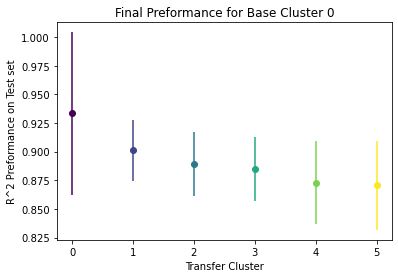

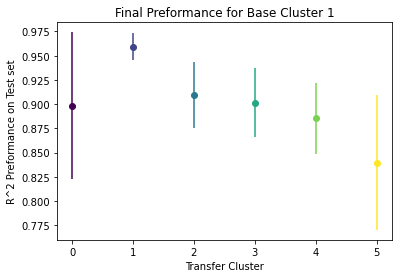

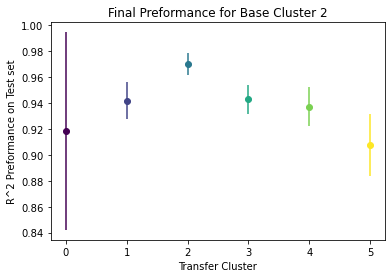

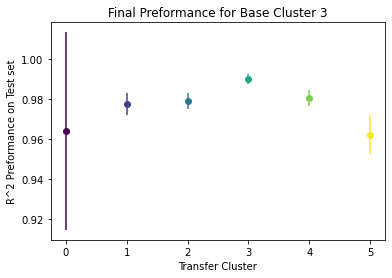

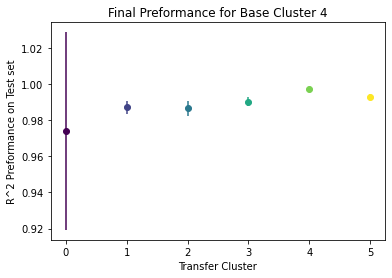

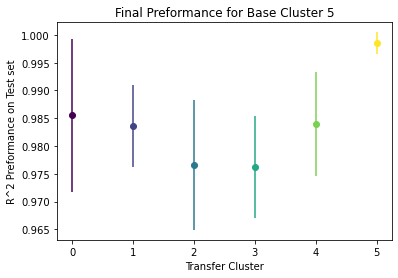

index -1 is out of bounds for axis 0 with size 0
error (0, 0)
integral,std_int,+1_std,normal
3.447807826471942 3.6491801409173097 36.282828282828284 31.242424242424242
integral,std_int,+1_std,normal
58.756537192438586 636.4388542623307 157.25252525252526 132.05050505050505
integral,std_int,+1_std,normal
201.93435332323855 635.8022239152408 192.53535353535355 162.2929292929293
integral,std_int,+1_std,normal
701.4981267391397 11284.374659772971 318.54545454545456 278.22222222222223
integral,std_int,+1_std,normal
329.3243012032365 2236.5423826846973 333.6666666666667 278.22222222222223


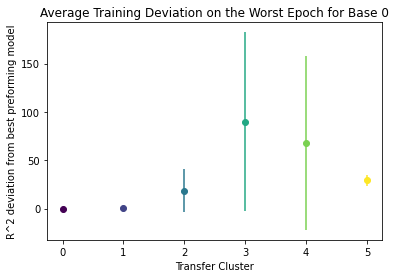

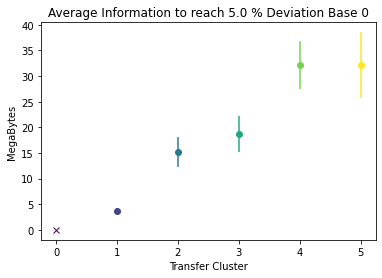

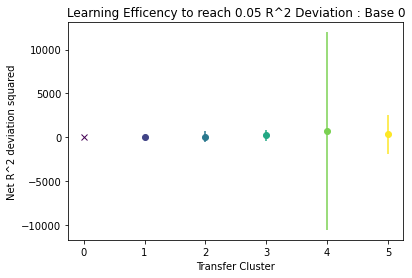

integral,std_int,+1_std,normal
11.262801349824183 25.72675428087533 121.96969696969697 76.60606060606061
index -1 is out of bounds for axis 0 with size 0
error (1, 1)
integral,std_int,+1_std,normal
5.1689780455109435 6.155835212131677 51.40404040404041 36.282828282828284
integral,std_int,+1_std,normal
124.96293382332506 105.88990378281407 137.0909090909091 116.92929292929294
integral,std_int,+1_std,normal
243.82175129195133 3441.7442982842117 192.53535353535355 157.25252525252526
integral,std_int,+1_std,normal
339.3705865686115 3054.6923724777084 273.1818181818182 212.69696969696972


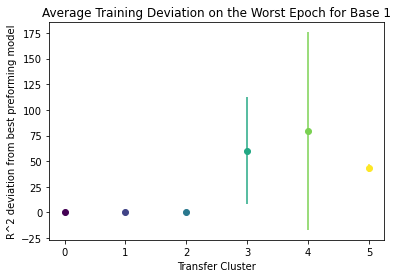

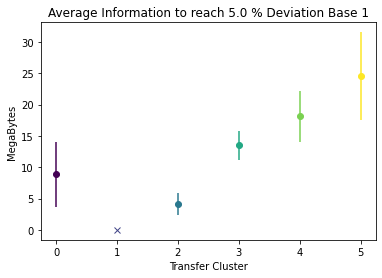

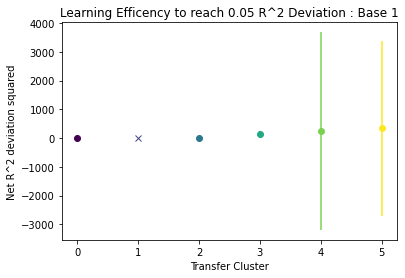

integral,std_int,+1_std,normal
24.87159182966568 67.87817333803758 288.3030303030303 152.21212121212122
integral,std_int,+1_std,normal
1.9341822722978952 2.5447561776840333 41.323232323232325 26.202020202020204
index -1 is out of bounds for axis 0 with size 0
error (2, 2)
integral,std_int,+1_std,normal
0.5654913735025404 1.4304251616287322 16.12121212121212 11.080808080808081
integral,std_int,+1_std,normal
79.94934815597365 408.231148269809 76.60606060606061 61.484848484848484
integral,std_int,+1_std,normal
71.02539833248387 51.38535524723919 278.22222222222223 247.97979797979798


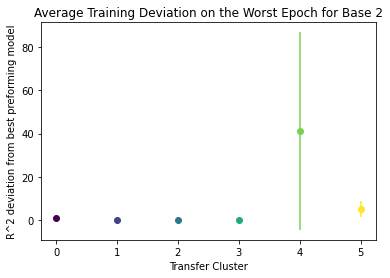

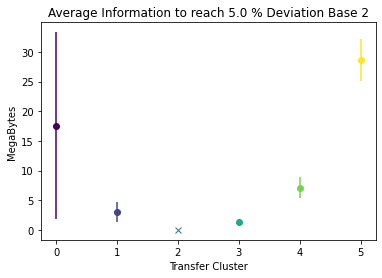

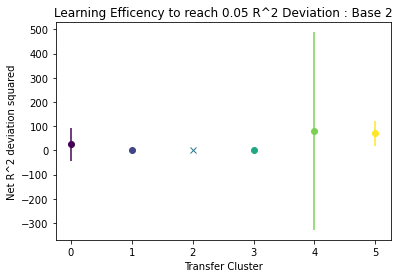

integral,std_int,+1_std,normal
22.677801105124296 38.20720412556317 212.69696969696972 127.01010101010101
integral,std_int,+1_std,normal
2.938288900664386 1.9996529624632582 41.323232323232325 31.242424242424242
integral,std_int,+1_std,normal
0.0 0.6181577307673343 11.080808080808081 6.040404040404041
index -1 is out of bounds for axis 0 with size 0
error (3, 3)
integral,std_int,+1_std,normal
8.674757043569937 4.4738036635228795 46.36363636363637 31.242424242424242
integral,std_int,+1_std,normal
38.987748841493946 22.021444876456535 247.97979797979798 207.65656565656568


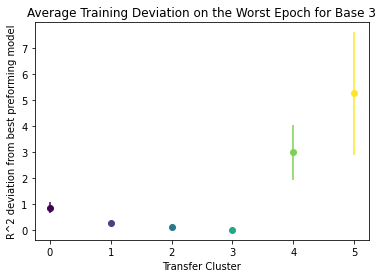

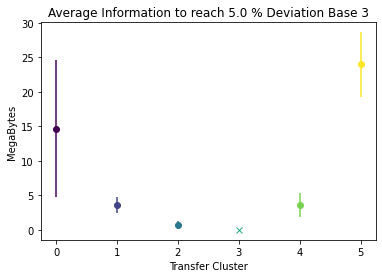

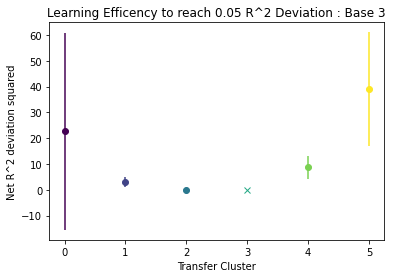

integral,std_int,+1_std,normal
28.57504810977172 42.15465142133642 217.73737373737376 137.0909090909091
integral,std_int,+1_std,normal
6.563554519483899 2.6252760727983375 46.36363636363637 36.282828282828284
integral,std_int,+1_std,normal
2.7234961139455724 1.2438219585637036 26.202020202020204 21.161616161616163
integral,std_int,+1_std,normal
1.691471130355638 0.7675399694844256 21.161616161616163 16.12121212121212
index -1 is out of bounds for axis 0 with size 0
error (4, 4)
integral,std_int,+1_std,normal
8.088978231780873 4.490094489066129 96.76767676767678 76.60606060606061


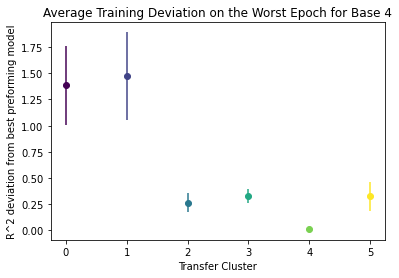

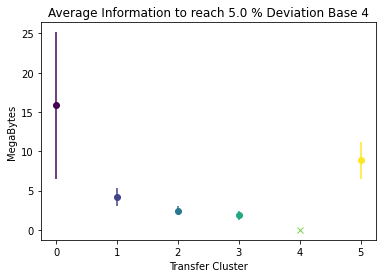

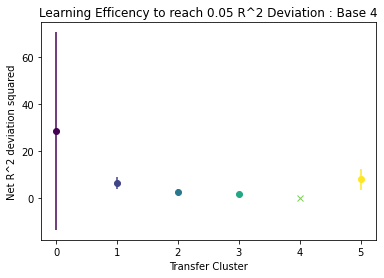

integral,std_int,+1_std,normal
13.31532921051353 9.312871025705538 96.76767676767678 56.44444444444445
integral,std_int,+1_std,normal
9.725914334619103 5.076681738886215 56.44444444444445 36.282828282828284
integral,std_int,+1_std,normal
14.079485864415147 9.070140199389712 106.84848484848486 76.60606060606061
integral,std_int,+1_std,normal
8.01257687752643 5.215886462569131 81.64646464646465 61.484848484848484
integral,std_int,+1_std,normal
2.199884980727549 2.1950946319611777 41.323232323232325 26.202020202020204
index -1 is out of bounds for axis 0 with size 0
error (5, 5)


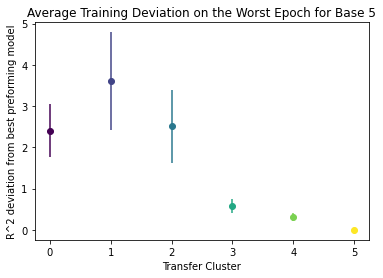

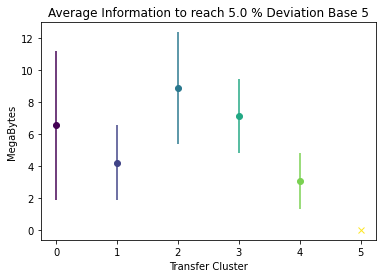

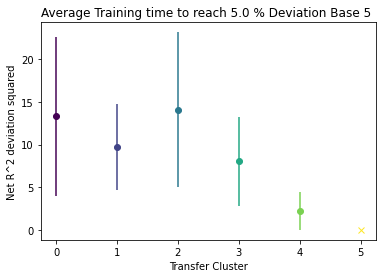

,Pc1,Pc2
Cluster,,
0,-3.544039,3.418156
1,-2.759969,0.638465
2,-1.570916,-0.855064
3,-0.129714,-0.473748
4,1.291237,-0.044567
5,2.664458,0.756521


c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


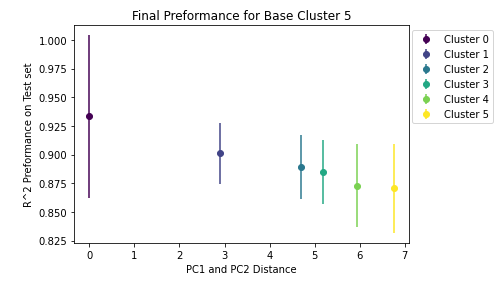

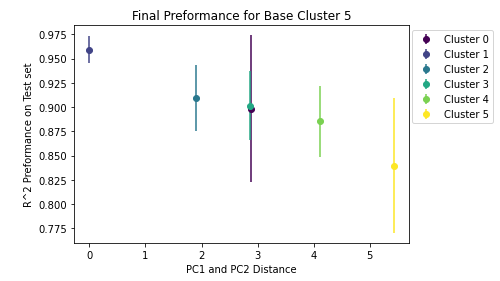

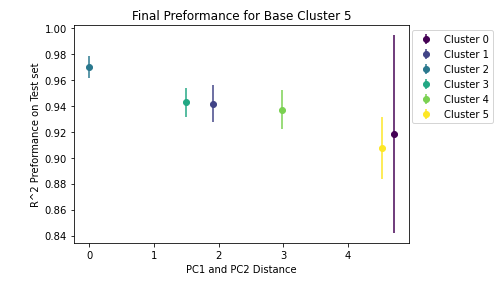

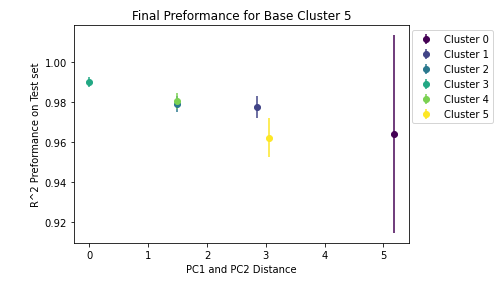

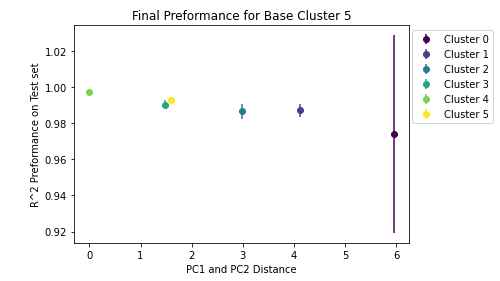

c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:306: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


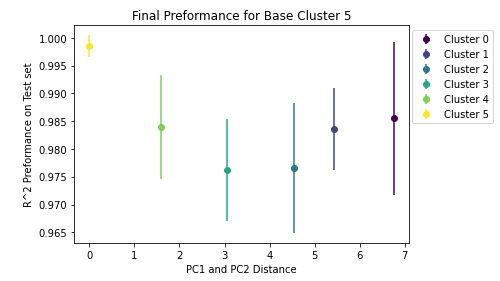

,Pc1
Cluster,
0,-3.544039
1,-2.759969
2,-1.570916
3,-0.129714
4,1.291237
5,2.664458


c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


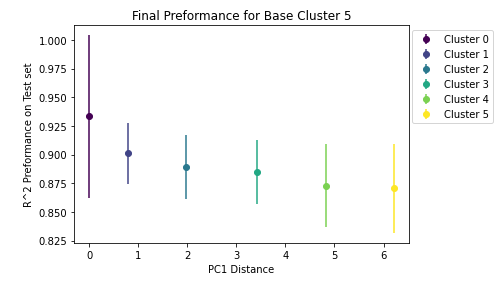

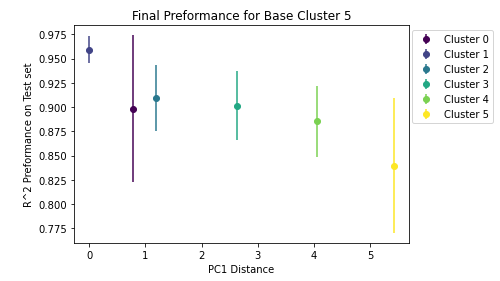

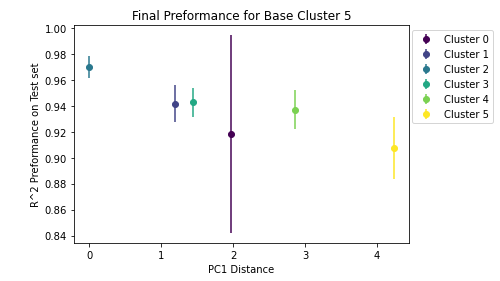

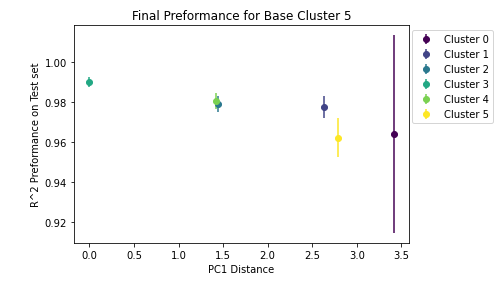

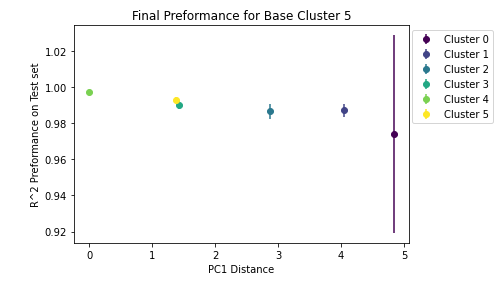

c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:306: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


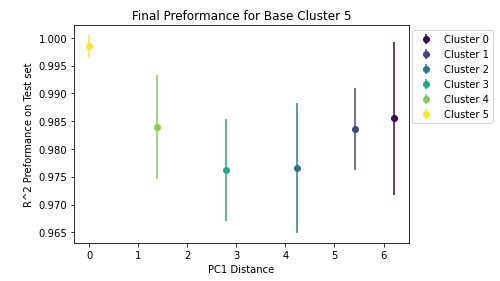

,Pc2
Cluster,
0,3.418156
1,0.638465
2,-0.855064
3,-0.473748
4,-0.044567
5,0.756521


c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


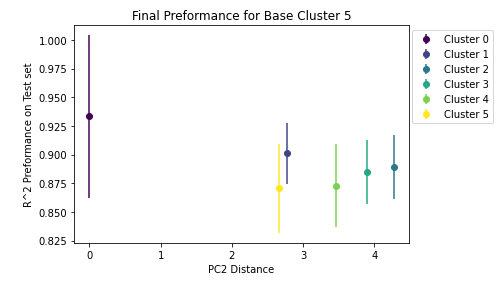

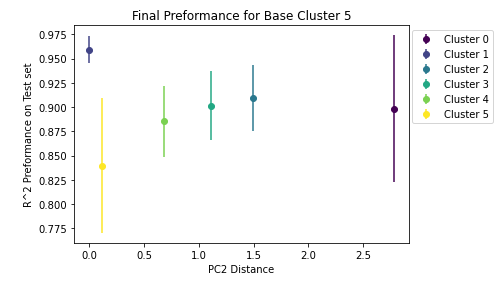

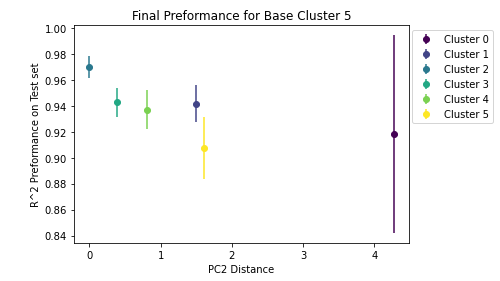

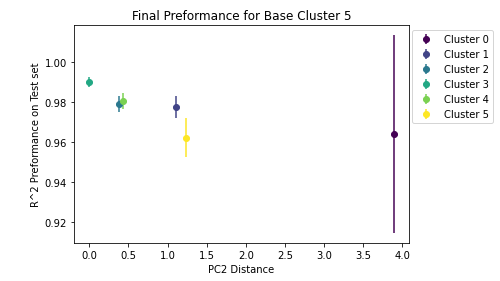

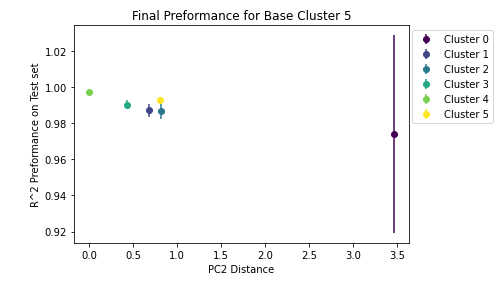

c:\Users\Greg\Desktop\version_1\trade1-repo\TL_MOF\Functions\engine.py:306: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


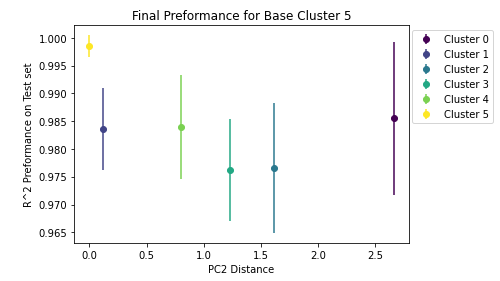

In [10]:
Cluster_colors=[
[0.267004, 0.004874, 0.329415, 1.      ],
[0.253935, 0.265254, 0.529983, 1.      ],
[0.163625, 0.471133, 0.558148, 1.      ],
[0.134692, 0.658636, 0.517649, 1.      ],
[0.477504, 0.821444, 0.318195, 1.      ],
[0.993248, 0.906157, 0.143936, 1.      ],]
dic,dic2,std=create_dictionaries(6)
dic=unpack_dic(dic,meta)
std=create_std_matrix(dic,std)
dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2,adjust=100,save=True)
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std,epochs,save=True)
import pandas as pd
from scipy.spatial import distance_matrix
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"Cluster"]]=abridge[['Pc1', 'Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors,"PC1 and PC2",save=True)
hold=pd.DataFrame()
hold[['Pc1',"Cluster"]]=abridge[['Pc1',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors,"PC1",save=True)
hold=pd.DataFrame()
hold[['Pc2',"Cluster"]]=abridge[['Pc2',"Cluster"]]
display(hold.groupby("Cluster").median())
distances=distance_matrix(hold.groupby("Cluster").median(),hold.groupby("Cluster").median())
make_distance_graph(dic,distances,Cluster_colors,"PC2",save=True)

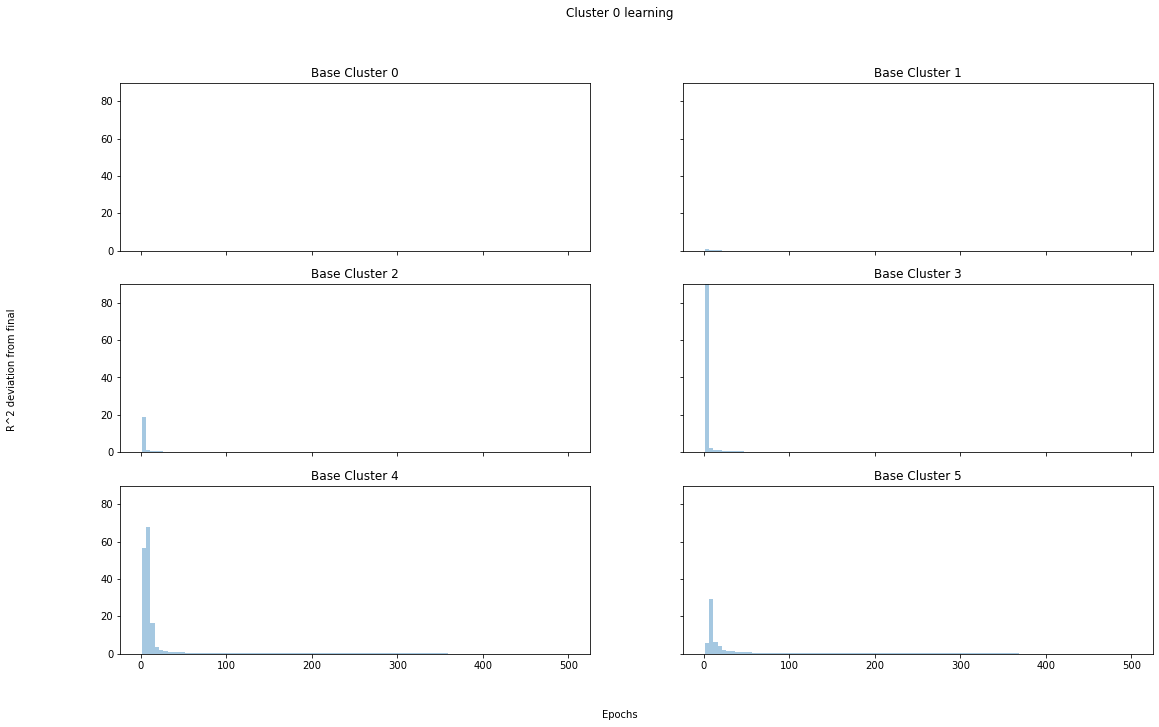

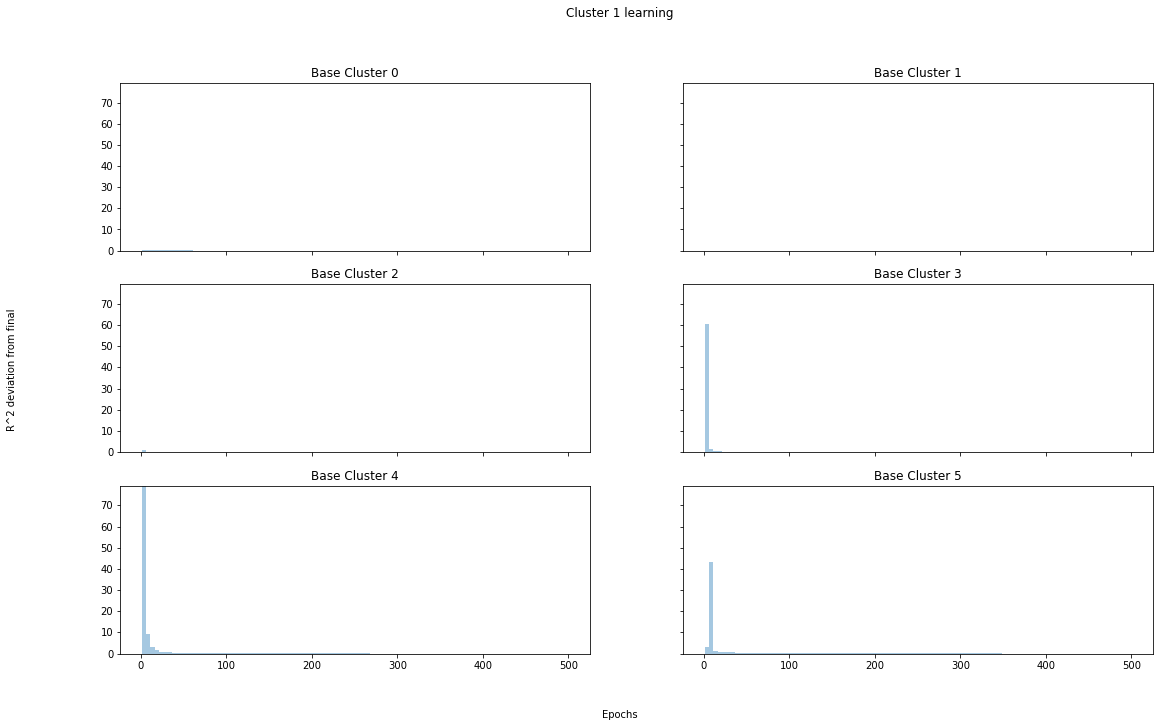

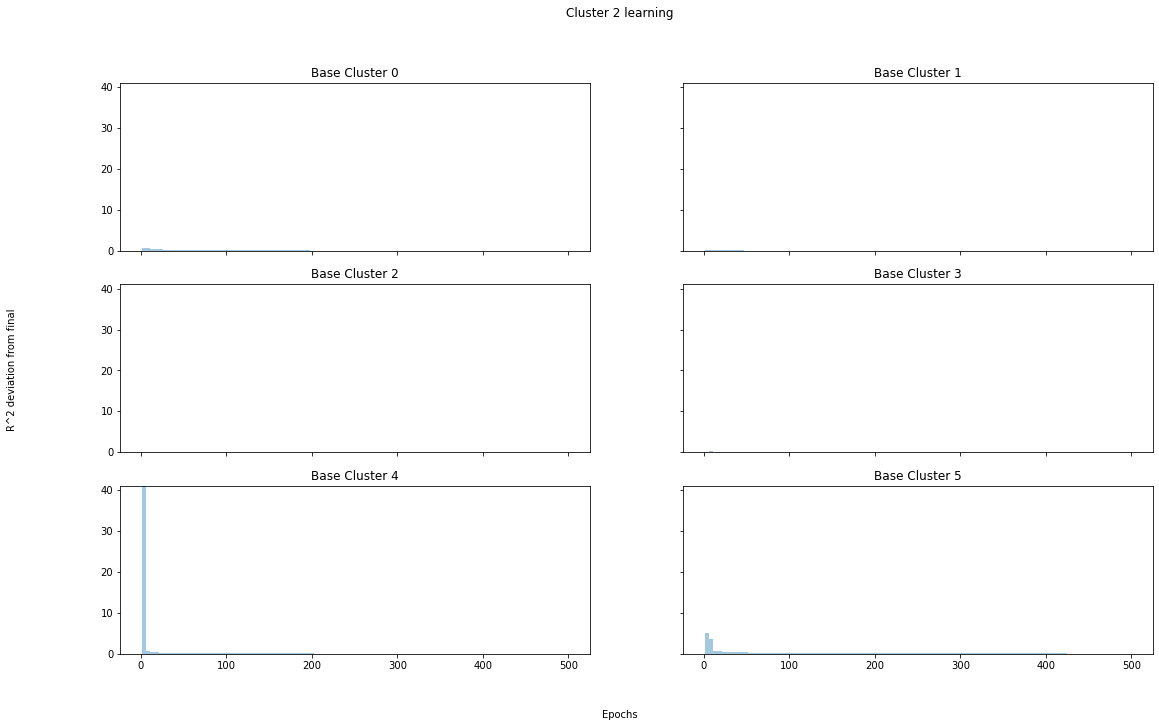

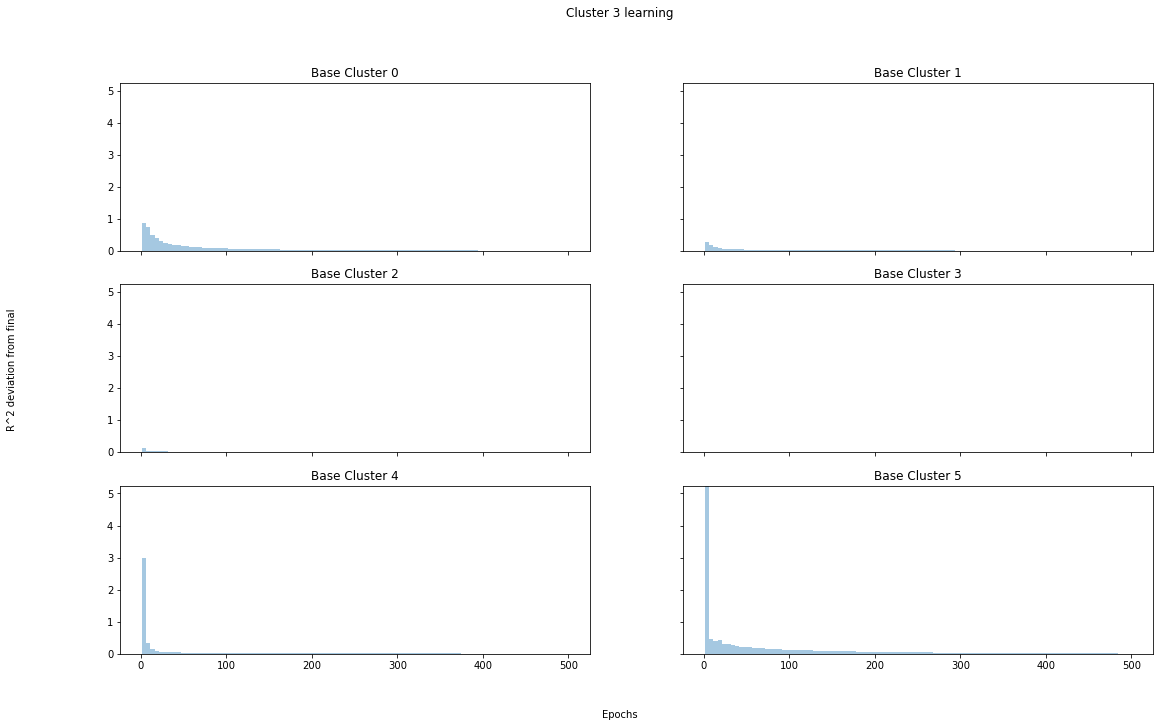

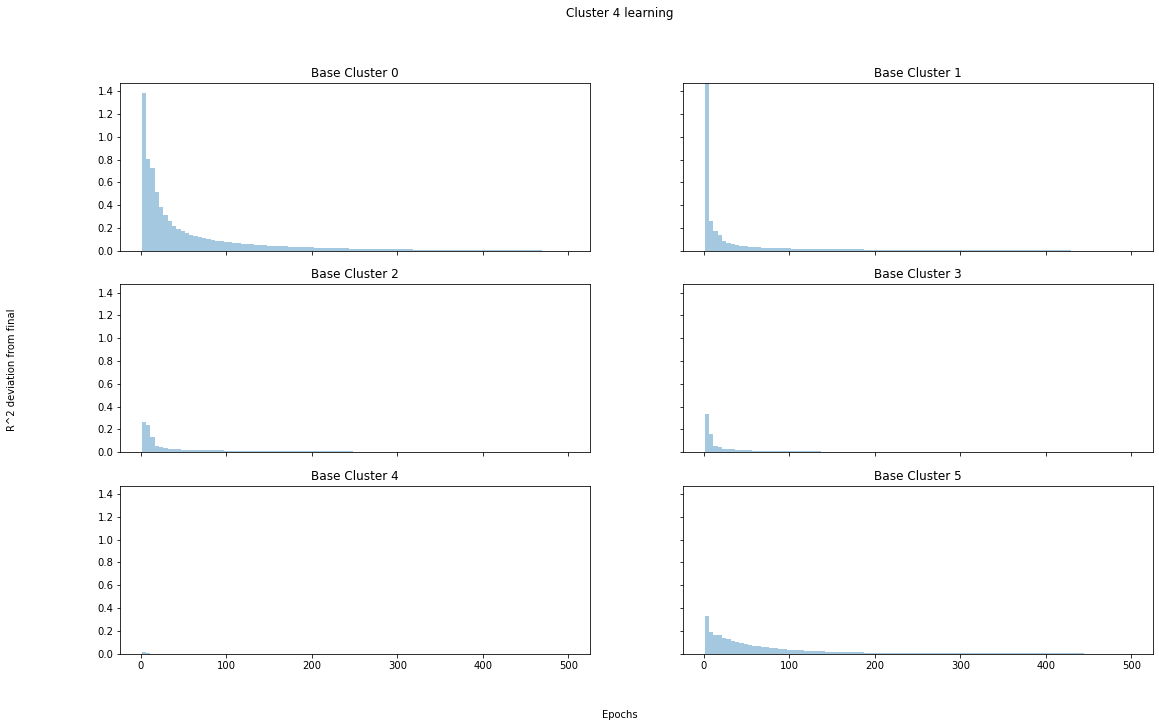

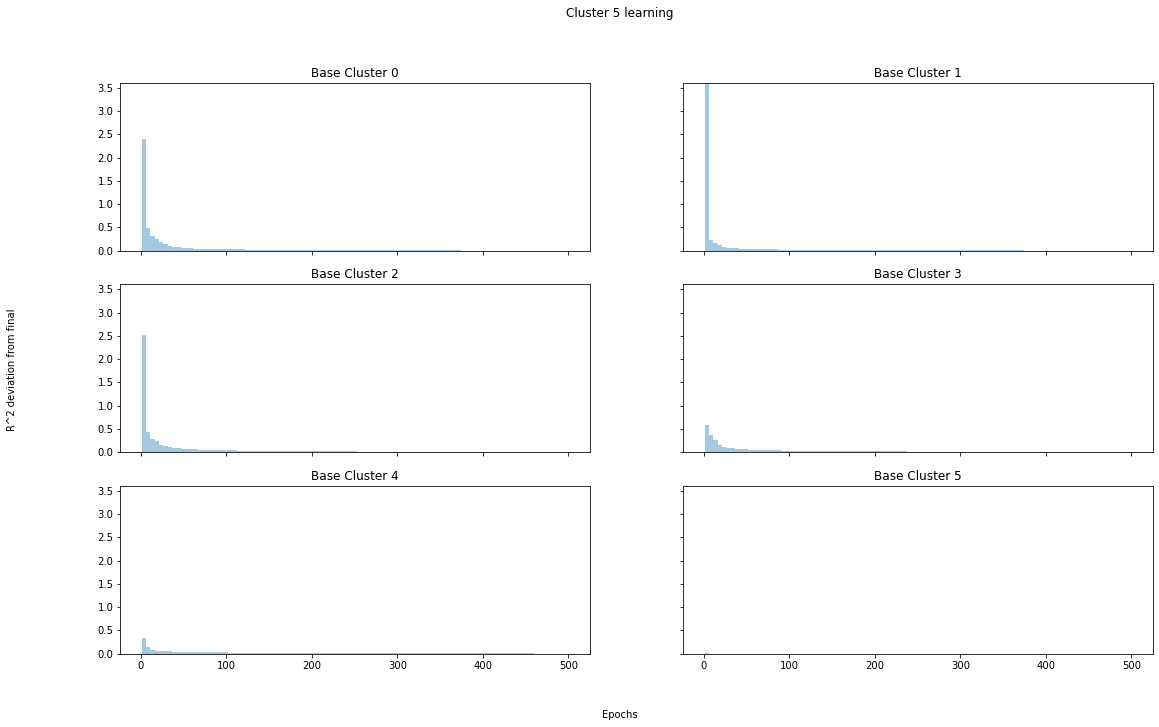

In [11]:
import numpy as np
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[g][count]=np.array(base[g][count])+np.array(z)
anaylsis(base,adjust=100)